# **GIS × Python Tutorial 7.2 ~ Rasterデータの投影変換 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br>


## **はじめに**
---
今回は GDAL での投影変換と落とし穴について解説していきます。

今回記事の執筆に使用した Notebook と Conda環境ファイル（geome.yaml）は GitHub に公開しているので、実行してみたい方はどうぞ。

<br>


## **投影変換とは**
---
GISデータを現在の座標系から別の座標系に変換する作業の事です。例えば「EPSG:4326」➡「EPSG:6678」のような感じです。


## **コード実行の準備**

### **Import**


In [12]:
import os

import geopandas as gpd
import japanize_matplotlib
import numpy as np
from matplotlib import pyplot as plt
from osgeo import gdal, osr
import pyproj
import shapely
from shapely.plotting import plot_polygon
japanize_matplotlib.japanize()

DIR_NAME = r'..\images\session7'
RASTER_FILE = os.path.join(DIR_NAME, 'RASTER.tif')
REPROJ_GDAL = os.path.join(DIR_NAME, 'REPROJ_GDAL.tif')

IN_EPSG = 6678
IN_SRS = osr.SpatialReference()
IN_SRS.ImportFromEPSG(IN_EPSG)
IN_SRS_WKT = IN_SRS.ExportToWkt()

OUT_EPSG = 4326
OUT_SRS = osr.SpatialReference()
OUT_SRS.ImportFromEPSG(OUT_EPSG)
OUT_SRS_WKT = OUT_SRS.ExportToWkt()

### **Rasterデータの作成**
とりあえず最初に投影変換する為の Raster データを作成します。EPSGコードは[6678]で青森県弘前市にある弘前城周辺に投影してみましょう。

In [50]:
# データの作成
cols = 20
rows = 15
image = []
for _ in range(3):
    img = np.array([np.random.randint(0, 256, cols) for i in range(rows)])
    image.append(img)

image = np.array(image)


driver = gdal.GetDriverByName('MEM')
driver.Register()
org_dst = driver.Create(
    '',
    xsize=image[0].shape[1], 
    ysize=image[0].shape[0], 
    bands=3, 
    eType=gdal.GDT_Byte
)
transform = (-31270.0, 5.0, 0.0, 67573.0, 0.0, -5.0)
org_dst.SetGeoTransform(transform)
org_dst.SetProjection(IN_SRS_WKT)
for i in range(1, 4):
    band = org_dst.GetRasterBand(i)
    band.WriteArray(image[i-1])
    print(i)
org_dst.FlushCache()

1
2
3


0

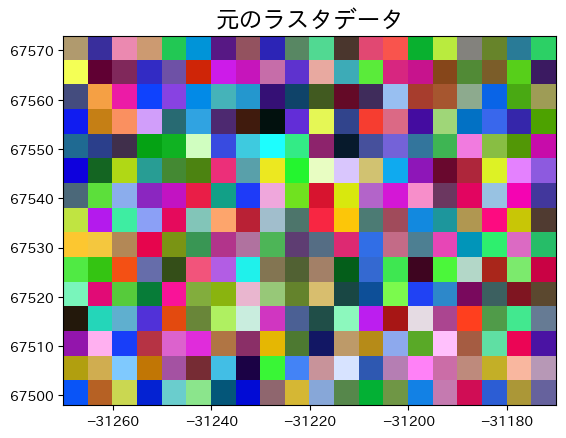

In [73]:
def get_bounds(dst: gdal.Dataset):
    # ラスタデータの範囲を取得する関数（gdal）
    transform = dst.GetGeoTransform()
    x_min = transform[0]
    y_max = transform[3]
    rows = dst.RasterYSize
    cols = dst.RasterXSize
    x_resol = transform[1]
    y_resol = transform[-1]
    x_max = x_min + cols * x_resol
    y_min = y_max + rows * y_resol
    return (x_min, y_min, x_max, y_max)


def plot_raster(dst, title):
    # ラスタデータをプロットする関数
    raster = org_dst.ReadAsArray()
    bounds = get_bounds(dst)
    # Matplotlibで表示する範囲の指定
    extent = [bounds[0], bounds[2], bounds[1], bounds[3]]
    plt.title(title, fontsize=17, fontweight='bold')
    plt.imshow(np.dstack(raster), extent=extent)
    plt.show()



plot_raster(org_dst, '元のラスタデータ')

## **GDALでの投影変換**
---

まずは後から検証に使用する為に投影変換後の Dataset から Raster の投影範囲を取得し、元の平面直角座標系の座標に戻す関数を作成しておきます。

In [67]:
def get_local_bounds(wgs_dst):
    # 投影変換後のデータの範囲を取得し、平面直角座標系に戻す
    transformer = pyproj.Transformer.from_crs(    
        crs_from=OUT_SRS_WKT,
        crs_to=IN_SRS_WKT,
        always_xy=True
    )
    bounds = get_bounds(wgs_dst)
    xx = [bounds[0], bounds[2]]
    yy = [bounds[1], bounds[3]]
    transformed = transformer.transform(xx, yy)
    x_min, x_max = transformed[0]
    y_min, y_max = transformed[1]
    return (x_min, y_min, x_max, y_max)

### **IOのSRSだけ指定した投影変換**

GDAL での投影変換は`gdal.Warp`で行います。最初は入力ファイルのSRSと出力ファイルのSRSのみを指定して投影変換を行ってみましょう。

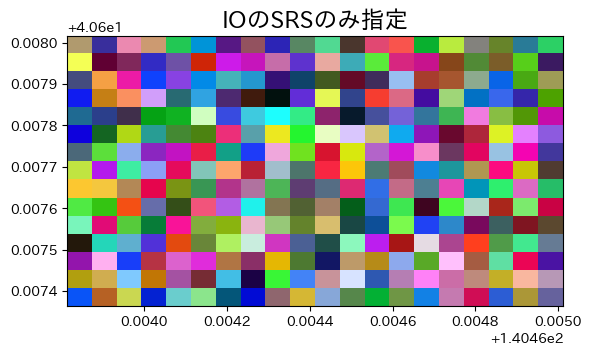

In [119]:
io_srs_dst = gdal.Warp(
    # 入力ファイルパス
    destNameOrDestDS='',
    srcDSOrSrcDSTab=org_dst,
    # オプション設定
    options=gdal.WarpOptions(
        # ファイルとして出力せずに、メモリ上に出力
        format='MEM',
        # 入力ファイルの空間参照系（EPSG:6678）
        srcSRS=org_dst.GetProjectionRef(),
        # 出力ファイルの空間参照系（EPSG:4326）
        dstSRS=OUT_SRS,
        # リサンプリングアルゴリズム
        resampleAlg=gdal.GRA_CubicSpline
    )
)

# あとから検証に使用する
bounds_dict = {
    'Original': {
        'bounds': get_bounds(org_dst), 
        'x_size': org_dst.RasterXSize, 
        'y_size': org_dst.RasterYSize
    },
    'IOのSRSのみ指定': {
        'bounds': get_local_bounds(io_srs_dst), 
        'x_size': io_srs_dst.RasterXSize, 
        'y_size': io_srs_dst.RasterYSize
    }
}

plot_raster(io_srs_dst, 'IOのSRSのみ指定')

これで Raster データを投影変換する事ができます。非常に簡単ですが、Raster の投影変換には注意が必要です。

以下の図をみて下さい投影変換後の範囲を元の SRS に投影変換（戻す）した範囲を Plot してみると、元の位置に戻っていない事が確認できます。また、Raster に記録した行列のサイズも変わっているのが分かります。VectorData と違い RasterData は点のデータではなく、面（セル）のデータなので、ピッタリと元の位置と同じ場所に投影変換する事は出来ず、不可逆の変換になっているようです。大きな範囲の RasterData であれば、このままでもあまり影響はないかもしれませんが、小さな範囲の RasterData でこの様に座標がズレて不可逆になるのはあまりよろしくありませんので、`gdal.WarpOptions` を設定して変化があるのかを見てみましょう。

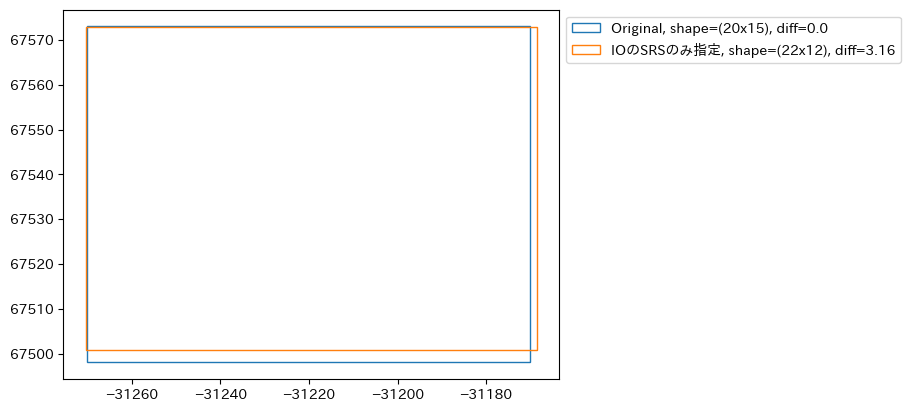

In [120]:
def plot_bounds(bounds_dict):
    # バウンディングボックスをプロットする関数
    # 
    base_bounds = bounds_dict['Original']['bounds']
    base_pt = shapely.Point(base_bounds[2], base_bounds[1])
    diff_lst = []
    for i, (label, item) in enumerate(bounds_dict.items()):
        _bounds = item.get('bounds')
        pt = shapely.Point(_bounds[2], _bounds[1])
        diff_lst.append(round(pt.distance(base_pt), 2))
    # バウンディングボックスをプロットする関数
    colors = plt.get_cmap('tab10').colors
    fig, ax = plt.subplots()
    for i, (label, items) in enumerate(bounds_dict.items()):
        geom = shapely.box(*items.get('bounds'))
        label = f"{label}, shape=({items.get('x_size')}x{items.get('y_size')}), diff={diff_lst[i]}"
        plot_polygon(
            geom, ax, edgecolor=colors[i], facecolor='none', 
            label=label, add_points=False
        )
    plt.legend(bbox_to_anchor=(1., 1))
    plt.show()



plot_bounds(bounds_dict)

## 出力後の範囲設定

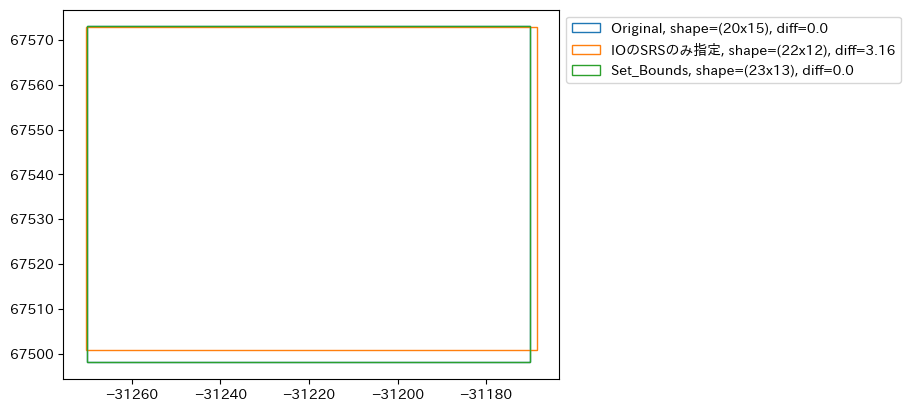

In [121]:
def reproject_bounds(org_dst, out_srs):
    # 投影変換後のデータの範囲を取得する
    bounds = get_bounds(org_dst)
    transformer = pyproj.Transformer.from_crs(    
        crs_from=org_dst.GetProjection(),
        crs_to=out_srs,
        always_xy=True
    )
    xx = [bounds[0], bounds[2]]
    yy = [bounds[1], bounds[3]]
    transformed = transformer.transform(xx, yy)
    x_min, x_max = transformed[0]
    y_min, y_max = transformed[1]
    return (x_min, y_min, x_max, y_max)



set_bounds_dst = gdal.Warp(
    # 入力ファイルパス
    destNameOrDestDS='',
    srcDSOrSrcDSTab=org_dst,
    # オプション設定
    options=gdal.WarpOptions(
        # ファイルとして出力せずに、メモリ上に出力
        format='MEM',
        # 入力ファイルの空間参照系（EPSG:6678）
        srcSRS=org_dst.GetProjectionRef(),
        # 出力ファイルの空間参照系（EPSG:4326）
        dstSRS=OUT_SRS,
        # 出力ファイルの範囲を指定
        outputBounds=reproject_bounds(org_dst, OUT_SRS_WKT),
        # リサンプリングアルゴリズム
        resampleAlg=gdal.GRA_CubicSpline
    )
)

bounds_dict['Set_Bounds'] = {
    'bounds': get_local_bounds(set_bounds_dst),
    'x_size': set_bounds_dst.RasterXSize, 
    'y_size': set_bounds_dst.RasterYSize
}

plot_bounds(bounds_dict)

範囲のずれはなくなりました。しかし行列のサイズは変わったままです。

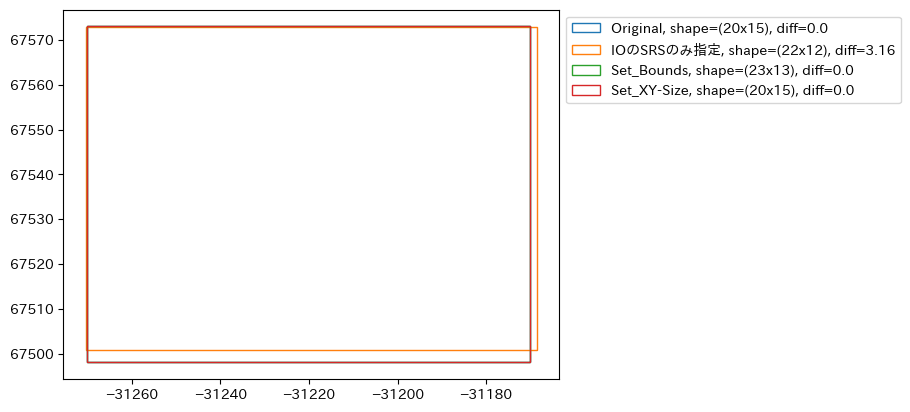

In [122]:
set_xy_size_dst = gdal.Warp(
    # 入力ファイルパス
    destNameOrDestDS='',
    srcDSOrSrcDSTab=org_dst,
    # オプション設定
    options=gdal.WarpOptions(
        # ファイルとして出力せずに、メモリ上に出力
        format='MEM',
        # 入力ファイルの空間参照系（EPSG:6678）
        srcSRS=org_dst.GetProjectionRef(),
        # 出力ファイルの空間参照系（EPSG:4326）
        dstSRS=OUT_SRS,
        # 出力ファイルの範囲を指定
        outputBounds=reproject_bounds(org_dst, OUT_SRS_WKT),
        # 出力ファイルのサイズを指定
        width=org_dst.RasterXSize,
        height=org_dst.RasterYSize,
        # リサンプリングアルゴリズム
        resampleAlg=gdal.GRA_CubicSpline
    )
)

bounds_dict['Set_XY-Size'] = {
    'bounds': get_local_bounds(set_xy_size_dst),
    'x_size': set_xy_size_dst.RasterXSize, 
    'y_size': set_xy_size_dst.RasterYSize
}

plot_bounds(bounds_dict)